Loaded seed ELO for 783 players from data/raw/atp_elo.csv
Found match files: 57
Total matches loaded: 194996
Available stats: ['ace', 'df', 'svpt', '1stin', '1stwon', '2ndwon']

🧠 Training Models...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [23:27:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [23:27:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [23:27:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [23:27:32] WARN


📊 Model Comparison:
              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression     67.65      67.66   67.61     67.63
      Random Forest     67.74      67.16   69.40     68.26
            XGBoost     67.84      67.73   68.15     67.94

📈 Generating ROC Curve comparison...

📊 Updated Model Comparison (with AUC):
              Model  Accuracy  Precision  Recall  F1-Score   AUC
Logistic Regression     67.65      67.66   67.61     67.63 0.743
      Random Forest     67.74      67.16   69.40     68.26 0.744
            XGBoost     67.84      67.73   68.15     67.94 0.746


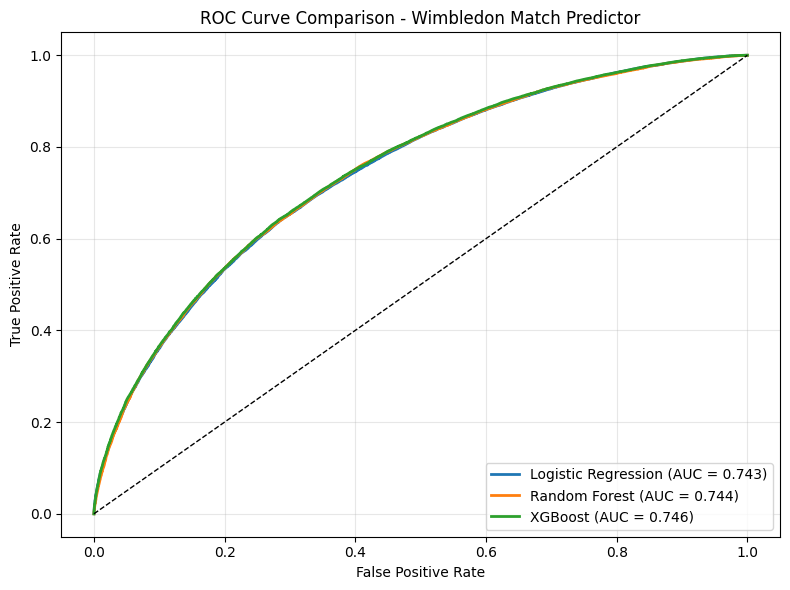

✅ ROC Curve saved as 'model/roc_curve_comparison.png'

✅ Models and scaler saved successfully.
Total runtime: 62.5 s


In [3]:
import pandas as pd
import numpy as np
from glob import glob
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings, re, time, os, sys
import joblib
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

start_time = time.time()

def read_csv_safely(path):
    encs = ["utf-8", "latin-1", "cp1252"]
    for e in encs:
        try:
            return pd.read_csv(path, low_memory=False, encoding=e)
        except Exception as exc:
            last_exc = exc
            continue
    raise last_exc

def normalize_name(s):
    if pd.isna(s): return ""
    s = str(s).replace("\xa0"," ").replace("\u200b","").strip()
    s = re.sub(r'\s+', ' ', s)
    return s.lower()

def safe_get(d, k, default=0.0):
    return d.get(k, default)

RECENT_N = 10
BASE_ELO = 1500.0
K_ELO = 32.0

elo_path = "data/raw/atp_elo.csv"
elo_seed = {}
if os.path.exists(elo_path):
    try:
        elo_df = read_csv_safely(elo_path)
        elo_name_col = next((c for c in elo_df.columns if 'player' in c.lower()), elo_df.columns[0])
        elo_df['player_name_norm'] = elo_df[elo_name_col].apply(normalize_name)
        elo_cols = [c for c in elo_df.columns if 'elo' in c.lower()]
        if elo_cols:
            elo_df['elo_overall'] = elo_df[elo_cols].apply(pd.to_numeric, errors='coerce').mean(axis=1).fillna(BASE_ELO)
        else:
            elo_df['elo_overall'] = BASE_ELO
        elo_seed = dict(zip(elo_df['player_name_norm'], elo_df['elo_overall']))
        print("Loaded seed ELO for", len(elo_seed), "players from", elo_path)
    except Exception as e:
        print("Warning: couldn't load elo file:", e)
        elo_seed = {}
else:
    print("No elo file found; will compute Elo online from BASE_ELO.")

files = sorted(glob("data/raw/atp_matches_*.csv"))
if not files:
    raise FileNotFoundError("No files found matching atp_matches_*.csv in working dir.")

print("Found match files:", len(files))
frames = []
for f in files:
    try:
        frames.append(read_csv_safely(f))
    except Exception as e:
        print(f"⚠️ Skipping {f} due to read error: {e}")
df = pd.concat(frames, ignore_index=True)
print("Total matches loaded:", len(df))

df.columns = [c.strip().lower() for c in df.columns]
winner_col = next((c for c in df.columns if 'winner' in c and 'name' in c), None)
loser_col  = next((c for c in df.columns if 'loser' in c and 'name' in c), None)
df['winner_norm'] = df[winner_col].apply(normalize_name)
df['loser_norm'] = df[loser_col].apply(normalize_name)
surface_col = next((c for c in df.columns if 'surface' in c), None)
df['surface'] = df[surface_col].astype(str).fillna('unknown') if surface_col else 'unknown'

date_col = next((c for c in df.columns if 'date' in c or 'tourney_date' in c), None)
if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.sort_values(date_col).reset_index(drop=True)

candidates = ['ace','df','svpt','1stin','1stwon','2ndwon','svwon','bp_faced','bp_saved','rank','rank_points','age','ht']
available_stats = [s for s in candidates if f"w_{s}" in df.columns and f"l_{s}" in df.columns]
for s in available_stats:
    for pref in ['w_','l_']:
        df[f"{pref}{s}"] = pd.to_numeric(df.get(f"{pref}{s}", np.nan), errors='coerce')
print("Available stats:", available_stats)

cum_sum = defaultdict(lambda: defaultdict(float))
cum_count = defaultdict(lambda: defaultdict(int))
recent_results = defaultdict(lambda: deque(maxlen=RECENT_N))
elo = defaultdict(lambda: BASE_ELO)
elo.update(elo_seed)

features_list, labels = [], []
for idx, row in df.iterrows():
    w, l = row['winner_norm'], row['loser_norm']
    surf = str(row.get('surface','unknown')).lower()
    feat = {}
    for s in available_stats:
        avg_w = cum_sum[w][s]/cum_count[w][s] if cum_count[w][s]>0 else np.nan
        avg_l = cum_sum[l][s]/cum_count[l][s] if cum_count[l][s]>0 else np.nan
        feat[f'diff_pref_{s}'] = avg_w - avg_l
    feat['elo_diff'] = elo[w] - elo[l]
    feat['recent_wr_diff'] = np.mean(recent_results[w]) - np.mean(recent_results[l]) if len(recent_results[w])>0 and len(recent_results[l])>0 else np.nan
    feat['surface'] = surf
    features_list.append(feat); labels.append(1)
    for s in available_stats:
        wval, lval = row.get(f"w_{s}", np.nan), row.get(f"l_{s}", np.nan)
        if not pd.isna(wval): cum_sum[w][s]+=wval; cum_count[w][s]+=1
        if not pd.isna(lval): cum_sum[l][s]+=lval; cum_count[l][s]+=1
    recent_results[w].append(1); recent_results[l].append(0)
    ew = 1/(1+10**((elo[l]-elo[w])/400)); elo[w]+=K_ELO*(1-ew); elo[l]+=K_ELO*(0-(1-ew))

numeric_feature_names = [f'diff_pref_{s}' for s in available_stats] + ['elo_diff', 'recent_wr_diff']
surfaces = sorted({feat['surface'] for feat in features_list})
X_rows, y_rows = [], []
for feat in features_list:
    row_vals = {nf: feat.get(nf, np.nan) for nf in numeric_feature_names}
    for s in surfaces:
        row_vals[f"surface_{s}"] = 1.0 if feat['surface']==s else 0.0
    X_rows.append(row_vals); y_rows.append(1)
    row_vals_neg = {k: (-v if isinstance(v,(int,float)) and not k.startswith("surface_") else v) for k,v in row_vals.items()}
    X_rows.append(row_vals_neg); y_rows.append(0)

X_df = pd.DataFrame(X_rows); y_arr = np.array(y_rows)
num_cols = [c for c in X_df.columns if not c.startswith('surface_')]
X_df[num_cols] = X_df[num_cols].fillna(X_df[num_cols].median())

X_train, X_test, y_train, y_test = train_test_split(X_df, y_arr, test_size=0.2, random_state=42, stratify=y_arr)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("\n🧠 Training Models...")

lr = LogisticRegression(max_iter=500, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    use_label_encoder=False,
    random_state=42
)
param_dist = {
    'n_estimators': [150, 300, 500],
    'max_depth': [3,4,5,6],
    'learning_rate': [0.01,0.05,0.1],
    'subsample': [0.7,0.8,1.0],
    'colsample_bytree': [0.6,0.8,1.0],
}
search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10, scoring='accuracy', cv=3, n_jobs=-1, random_state=42)
search.fit(X_train_scaled, y_train)
best_model = search.best_estimator_
y_pred_xgb = best_model.predict(X_test_scaled)

def eval_model(name, y_true, y_pred):
    return {
        "Model": name,
        "Accuracy": round(accuracy_score(y_true, y_pred)*100, 2),
        "Precision": round(precision_score(y_true, y_pred)*100, 2),
        "Recall": round(recall_score(y_true, y_pred)*100, 2),
        "F1-Score": round(f1_score(y_true, y_pred)*100, 2)
    }

results = [
    eval_model("Logistic Regression", y_test, y_pred_lr),
    eval_model("Random Forest", y_test, y_pred_rf),
    eval_model("XGBoost", y_test, y_pred_xgb)
]
results_df = pd.DataFrame(results)
print("\n📊 Model Comparison:")
print(results_df.to_string(index=False))


print("\n📈 Generating ROC Curve comparison...")

y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]
y_prob_xgb = best_model.predict_proba(X_test_scaled)[:, 1]

auc_lr = roc_auc_score(y_test, y_prob_lr)
auc_rf = roc_auc_score(y_test, y_prob_rf)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

results_df["AUC"] = [round(auc_lr, 3), round(auc_rf, 3), round(auc_xgb, 3)]
print("\n📊 Updated Model Comparison (with AUC):")
print(results_df.to_string(index=False))

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})", lw=2)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})", lw=2)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})", lw=2)
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.title("ROC Curve Comparison - Wimbledon Match Predictor")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

roc_path = "model/roc_curve_comparison.png"
plt.tight_layout()
plt.savefig(roc_path, dpi=300)
plt.show()
print(f"✅ ROC Curve saved as '{roc_path}'")

os.makedirs("model", exist_ok=True)
joblib.dump(best_model, "model/model.pkl")
joblib.dump(scaler, "model/scaler.pkl")
joblib.dump(X_df.columns.tolist(), "model/feature_columns.pkl")
print("\n✅ Models and scaler saved successfully.")
print("Total runtime:", round(time.time()-start_time,1), "s")
